In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Reading Data

In [2]:
gdp_df = pd.read_csv('../data/gdp-data/SQGDP2__ALL_AREAS_2005_2021.csv')
vax_df = pd.read_csv('../data/vaccination-data/us_state_vaccinations.csv')

# Processing Vaccination Data

First, I'll aggregate states' vaccination rates per 1000 into quarterly numbers.

In [3]:
def find_quarter(date):
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    if datetime_object.month <= 3:
        return str(datetime_object.year)+":Q1"
    elif datetime_object.month <= 6:
        return str(datetime_object.year)+":Q2"
    elif datetime_object.month <= 9:
        return str(datetime_object.year)+":Q3"
    else:
        return str(datetime_object.year)+":Q4"

In [4]:
vax_df_quarterly = vax_df.copy()
vax_df_quarterly['quarter'] = vax_df_quarterly['date'].apply(find_quarter)

Cleaning the vaccination data set
* Removing unnecessary data columns
* Finding maxes per quarter (or for daily, aggregating per quarter)
* Removing locations that don't correlate with other data (pretty much restricting to states)
* Drop NA?

In [5]:
vax_df_quarterly = vax_df_quarterly[['quarter', 'location', 'people_fully_vaccinated_per_hundred', 
                                    'total_vaccinations_per_hundred', 'distributed_per_hundred',
                                    'daily_vaccinations_per_million']]

In [6]:
# Note - new york is listed as New York State for some reason, so we need to convert it to make state names match easily
vax_df_quarterly.loc[vax_df_quarterly['location'] == 'New York State', 'location'] = 'New York'

In [7]:
state_names = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

In [8]:
vax_df_quarterly = vax_df_quarterly[vax_df_quarterly['location'].isin(state_names)]

In [9]:
summarized_vax_quarterly = vax_df_quarterly.groupby(['quarter', 'location']).agg({'people_fully_vaccinated_per_hundred': 'max',
                                                                                'total_vaccinations_per_hundred': 'max',
                                                                                'distributed_per_hundred': 'max',
                                                                                'daily_vaccinations_per_million': 'mean'}).reset_index()

In [10]:
summarized_vax_quarterly

,quarter,location,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,distributed_per_hundred,daily_vaccinations_per_million
0,2021:Q1,Alabama,13.40,35.26,57.04,4178.782051
1,2021:Q1,Alaska,22.30,55.67,82.19,6542.525641
2,2021:Q1,Arizona,17.07,47.42,59.13,5634.564103
3,2021:Q1,Arkansas,13.90,39.21,58.44,5049.897436
4,2021:Q1,California,16.07,46.12,59.88,5410.820513
...,...,...,...,...,...,...
195,2021:Q4,Virginia,64.94,153.49,183.10,4179.885246
196,2021:Q4,Washington,65.04,149.41,183.54,3755.983607
197,2021:Q4,West Virginia,41.54,94.35,188.66,1341.377049
198,2021:Q4,Wisconsin,59.50,140.75,159.59,3907.081967


Note: this data only includes states from Q1 2021 to Q2 2022 because vaccine rollout was almost non-existent before Q1 2021, and the data collection pipelines were not state-specific. The final total_vaccinations_per_hundred on 11/30/2020 was .84

# Processing GDP Data and Merging into Summarized Vax

I'll start by dropping the unnecessary columns to avoid confusion.

Note, I removed the unit because everything is "Millions of current dollars" (not Real GDP chained to 2012, but instead current dollar values as of October 2021)

In [11]:
gdp_df = gdp_df[['GeoName','Description','2021:Q2','2021:Q1','2020:Q4','2020:Q3','2020:Q2','2020:Q1']]

Now I'll start cleaning osme of the data by keeping states consistent with the summarized vaccine data

In [12]:
gdp_df = gdp_df[gdp_df['GeoName'].isin(state_names)]

In [13]:
# Renaming for future merging
gdp_df = gdp_df.rename(columns={"GeoName": "location"})

In [14]:
gdp_df

,location,Description,2021:Q2,2021:Q1,2020:Q4,2020:Q3,2020:Q2,2020:Q1
29,Alabama,All industry total,243554.6,237303.0,232963.8,230033.7,211063.6,233524.8
30,Alabama,Private industries,204375.2,198544.6,194438.5,191715.1,173173.3,194793.0
31,Alabama,"Agriculture, forestry, fishing and hunting",1773.1,1763.6,1707.0,1194.6,621.1,2237.3
32,Alabama,"Mining, quarrying, and oil and gas extraction",2647.7,2481.3,2005.3,1708.0,1196.6,2064.8
33,Alabama,Utilities,6524.8,6670.8,6638.3,6811.8,6500.4,6264.6
...,...,...,...,...,...,...,...,...
1401,Wyoming,Other services (except government and gover...,650.5,630.1,645.1,632.1,543.4,673.8
1402,Wyoming,Government and government enterprises,6822.4,6763.2,6649.5,6586.9,6502.5,6661.2
1403,Wyoming,Federal civilian,1046.3,1018.5,1029.9,1011.8,1001.6,973.8
1404,Wyoming,Military,459.0,462.0,473.3,472.8,470.8,456.0


Creating a dataframe for only the total GDP. Also, we must reshape the data to create a new column for quarter as well as GDP in current dollars. This will make merging easier.

In [15]:
gdp_df_total = gdp_df[gdp_df['Description'] == 'All industry total'].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)

Calculating GDP growth rate

In [16]:
delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)

In [17]:
summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
summarized_gdp_total['delta_gdp_total'] = pd.concat([delta_2021_Q1,delta_2021_Q2])
summarized_gdp_total['location'] = pd.concat([gdp_df_total['location'],gdp_df_total['location']])
summarized_gdp_total.reset_index(drop=True, inplace=True)
summarized_gdp_total['quarter'] = pd.concat([pd.Series(['2021:Q1']*50),pd.Series(['2021:Q2']*50)]).to_list()

In [18]:
summarized_gdp_total

,quarter,location,delta_gdp_total
0,2021:Q1,Alabama,1.018626
1,2021:Q1,Alaska,1.023610
2,2021:Q1,Arizona,1.012526
3,2021:Q1,Arkansas,1.032001
4,2021:Q1,California,1.036554
...,...,...,...
95,2021:Q2,Virginia,1.026062
96,2021:Q2,Washington,1.035916
97,2021:Q2,West Virginia,1.040720
98,2021:Q2,Wisconsin,1.031773


Now we can join the two data sets for easy correlating (note, they only intersect in Q1 and Q2 2021)

In [19]:
summarized_total = summarized_vax_quarterly.merge(summarized_gdp_total, on=['location','quarter'])

In [20]:
summarized_total

,quarter,location,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,distributed_per_hundred,daily_vaccinations_per_million,delta_gdp_total
0,2021:Q1,Alabama,13.40,35.26,57.04,4178.782051,1.018626
1,2021:Q1,Alaska,22.30,55.67,82.19,6542.525641,1.023610
2,2021:Q1,Arizona,17.07,47.42,59.13,5634.564103,1.012526
3,2021:Q1,Arkansas,13.90,39.21,58.44,5049.897436,1.032001
4,2021:Q1,California,16.07,46.12,59.88,5410.820513,1.036554
...,...,...,...,...,...,...,...
95,2021:Q2,Virginia,51.81,108.14,121.35,6928.835165,1.026062
96,2021:Q2,Washington,54.51,112.46,123.20,7342.703297,1.035916
97,2021:Q2,West Virginia,37.19,79.10,105.45,3446.197802,1.040720
98,2021:Q2,Wisconsin,49.45,101.44,104.96,5830.945055,1.031773


# Examining Correlations

Correlating vaccination rates to the total GDP of states.

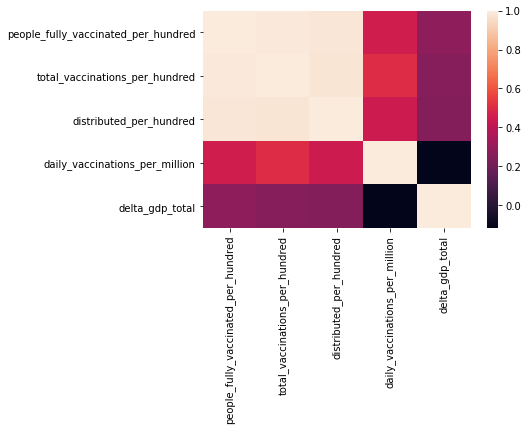

In [21]:
sns.heatmap(summarized_total.corr())

# Try to look for higher correlations for different values of "Description"

The following cell conducts the same analysis except for each possible value of "Description." This accounts for more specific categories.

All industry total
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.281565   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.259210   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

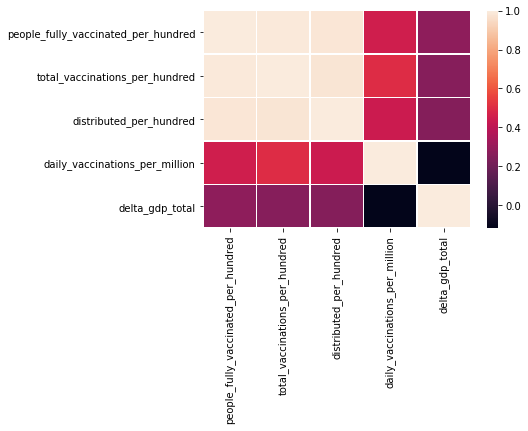

 Private industries
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.210603   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.192900   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hund

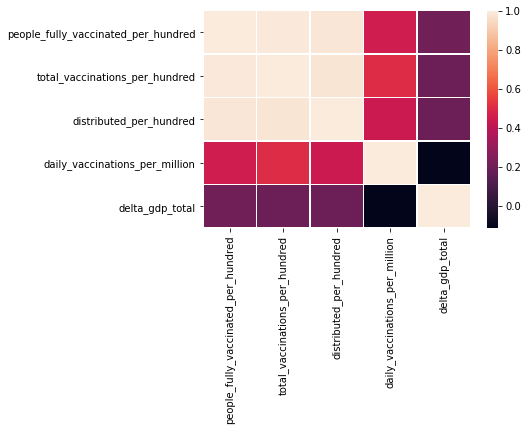

   Agriculture, forestry, fishing and hunting
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.275365   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.239200   

                                     distributed_per_hundred  \
people

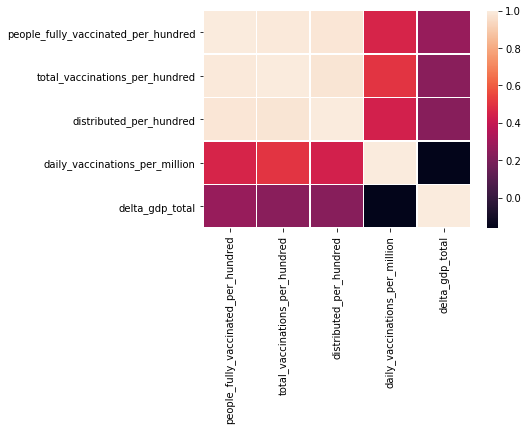

   Mining, quarrying, and oil and gas extraction
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                -0.672071   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                           -0.662365   

                                     distributed_per_hundred  \
peo

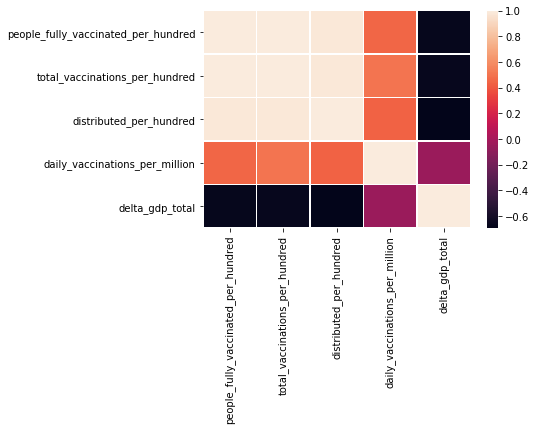

   Utilities
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                -0.696827   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                           -0.678444   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred    

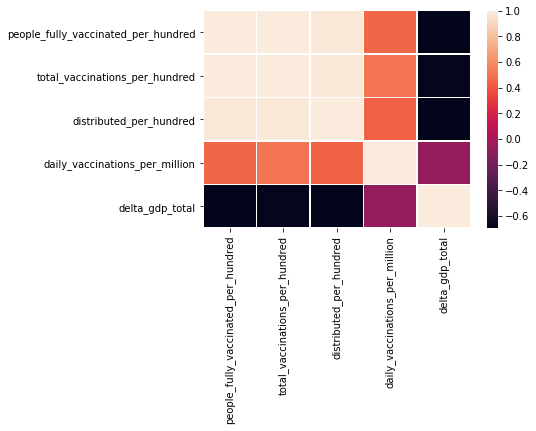

   Construction
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                -0.188556   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                           -0.177849   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred 

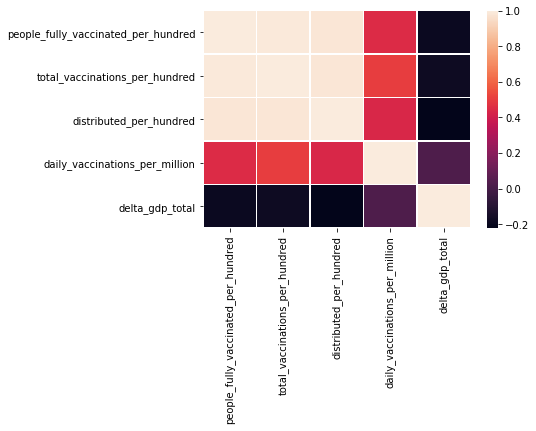

   Manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                -0.196786   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                           -0.182660   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred

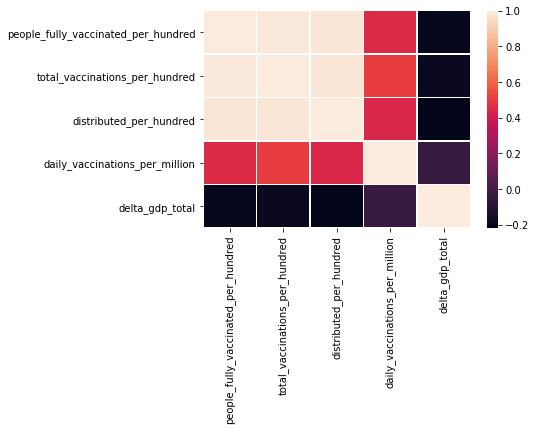

     Durable goods manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                -0.016765   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                           -0.022867   

                                     distributed_per_hundred  \
people_fully_vaccin

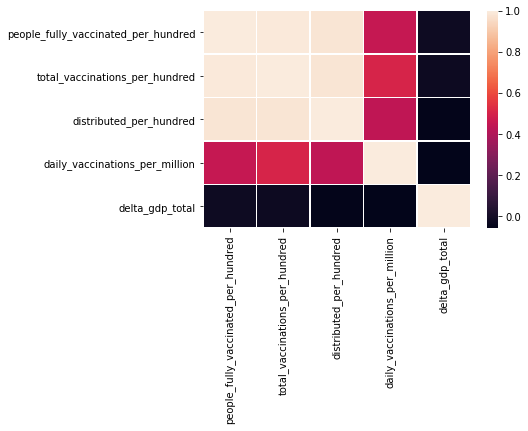

     Nondurable goods manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                -0.371093   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                           -0.344442   

                                     distributed_per_hundred  \
people_fully_vac

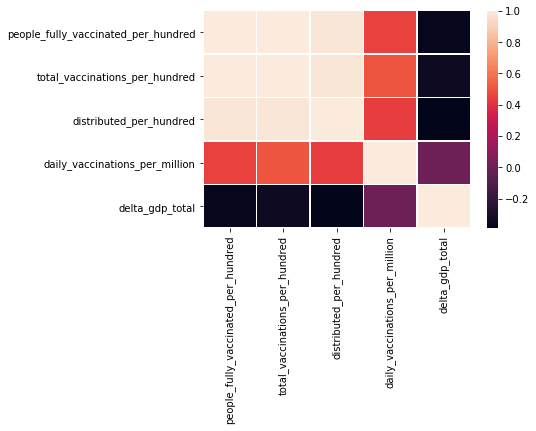

   Wholesale trade
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.334085   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.345684   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

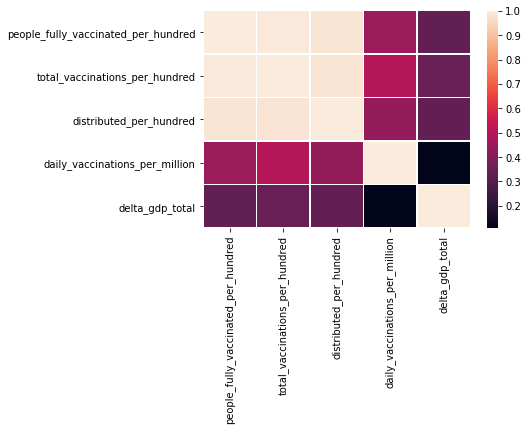

   Retail trade
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                -0.249031   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                           -0.241410   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred 

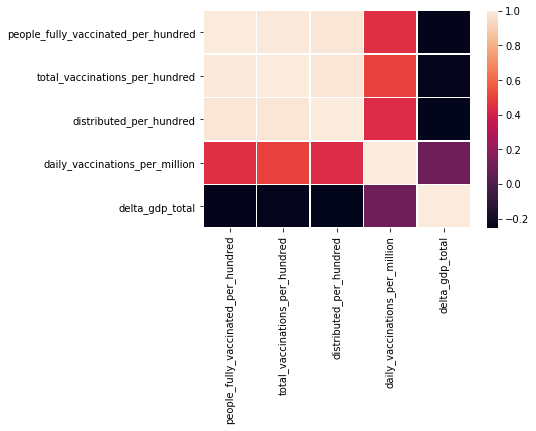

   Transportation and warehousing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.198964   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.204005   

                                     distributed_per_hundred  \
people_fully_vacci

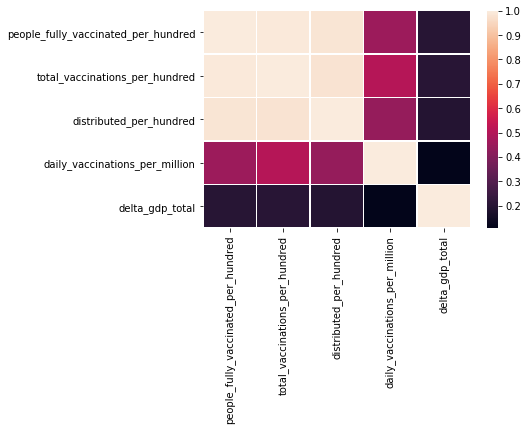

   Information
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.247516   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.245861   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred  

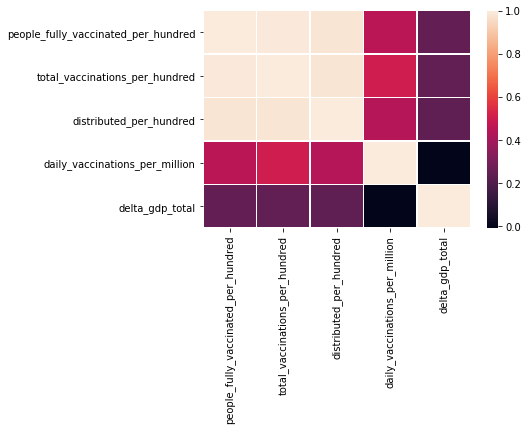

   Finance and insurance
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.419680   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.414850   

                                     distributed_per_hundred  \
people_fully_vaccinated_per

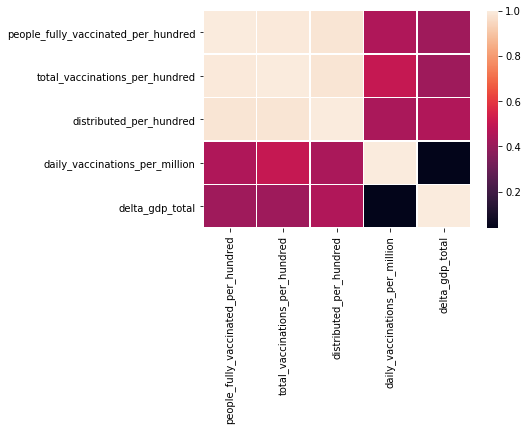

   Real estate and rental and leasing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.727329   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.712016   

                                     distributed_per_hundred  \
people_fully_v

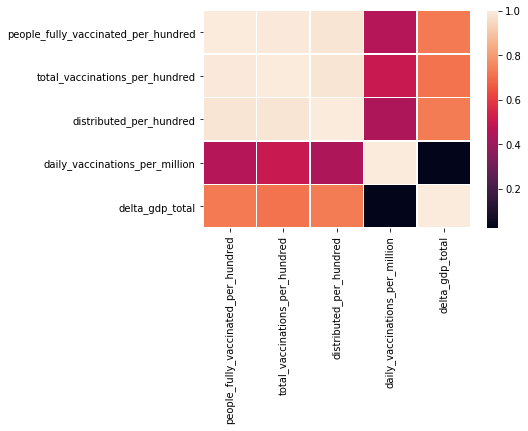

   Professional, scientific, and technical services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.208416   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.196743   

                                     distributed_per_hundred  \


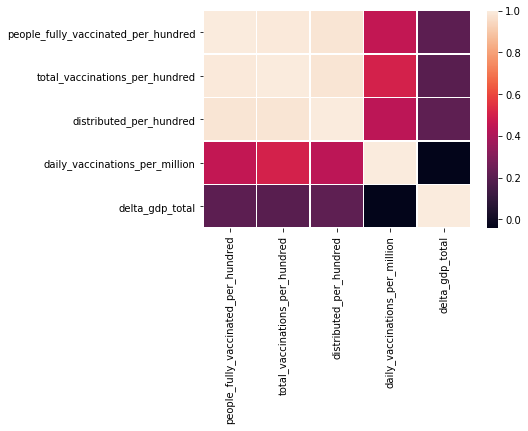

   Management of companies and enterprises
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                -0.136100   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                           -0.131984   

                                     distributed_per_hundred  \
people_fu

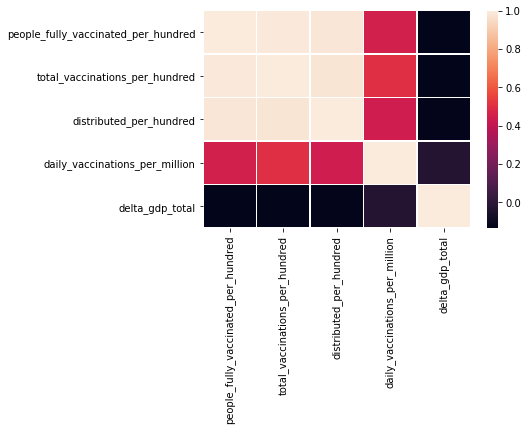

   Administrative and support and waste management and remediation services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                -0.385559   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                           -0.375625   

                                     dis

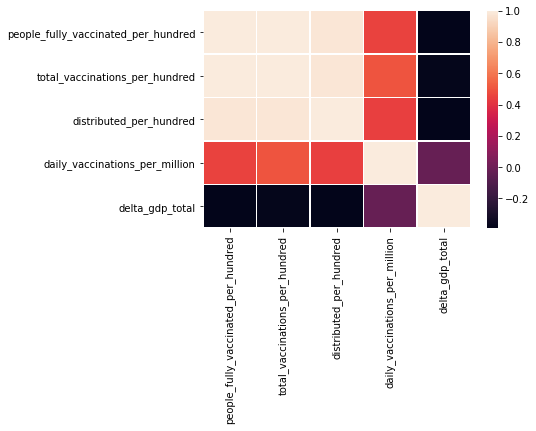

   Educational services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.247032   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.229219   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_

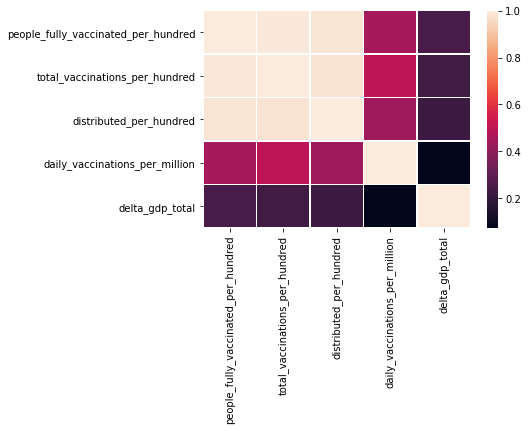

   Health care and social assistance
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.308606   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.294918   

                                     distributed_per_hundred  \
people_fully_va

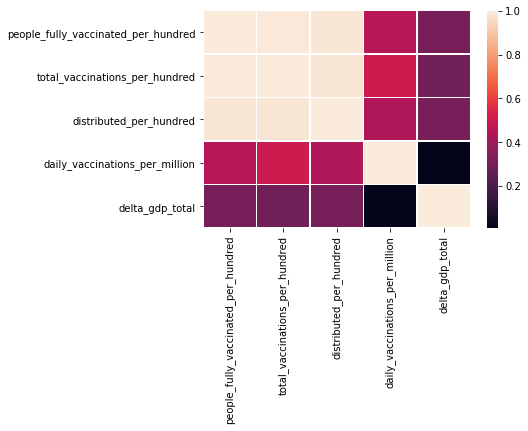

   Arts, entertainment, and recreation
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.095720   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.094147   

                                     distributed_per_hundred  \
people_fully_

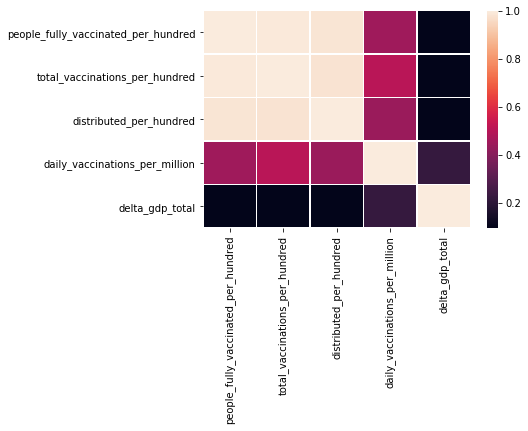

   Accommodation and food services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.782489   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.764932   

                                     distributed_per_hundred  \
people_fully_vacc

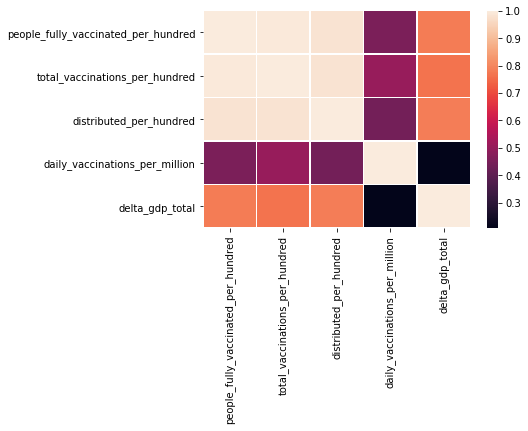

   Other services (except government and government enterprises)
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.833123   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.819133   

                                     distributed_pe

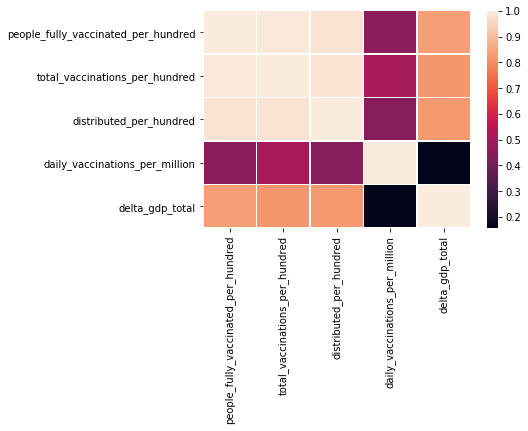

 Government and government enterprises
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.310312   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.289938   

                                     distributed_per_hundred  \
people_fully_

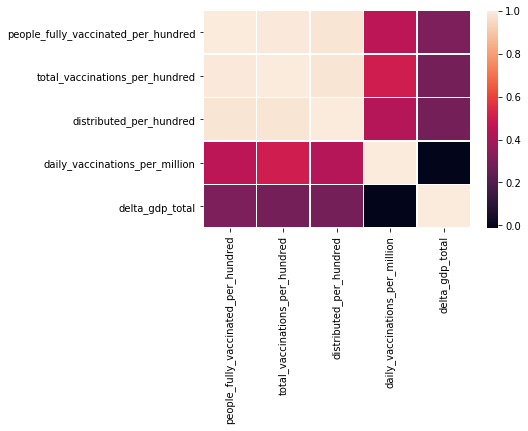

  Federal civilian
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.438139   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.431752   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

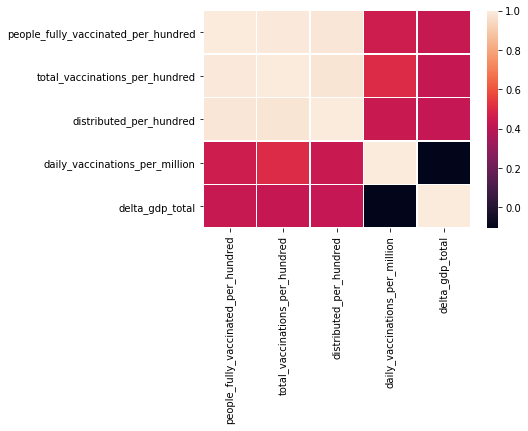

  Military
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                -0.119322   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                           -0.123459   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred      

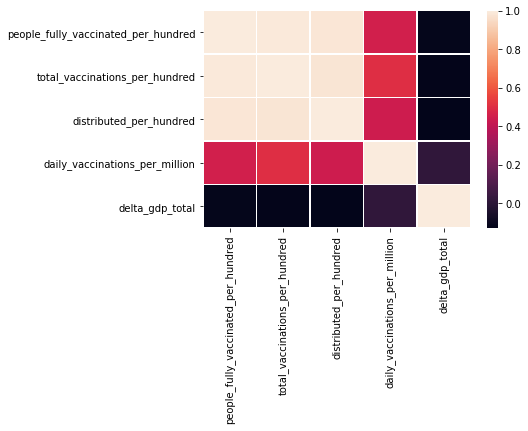

  State and local
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.994771   
distributed_per_hundred                                         0.982822   
daily_vaccinations_per_million                                  0.454884   
delta_gdp_total                                                 0.331540   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.994771   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981746   
daily_vaccinations_per_million                             0.505265   
delta_gdp_total                                            0.317700   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundre

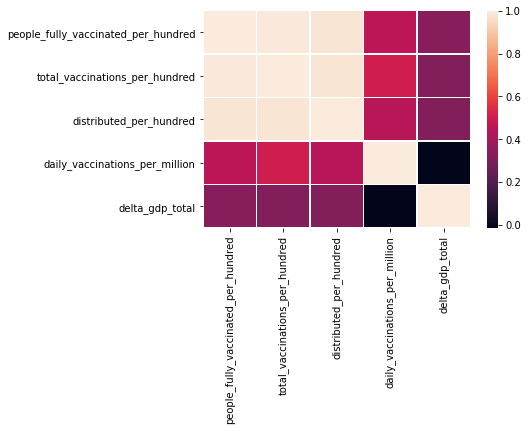

In [22]:
for description_value in gdp_df['Description'].unique():
    gdp_df_total = gdp_df[gdp_df['Description'] == description_value].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)
    gdp_df_total.replace('(D)',None,inplace=True)
    delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
    delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)
    summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
    summarized_gdp_total['delta_gdp_total'] = pd.concat([delta_2021_Q1,delta_2021_Q2])
    summarized_gdp_total['location'] = pd.concat([gdp_df_total['location'],gdp_df_total['location']])
    summarized_gdp_total.reset_index(drop=True, inplace=True)
    summarized_gdp_total['quarter'] = pd.concat([pd.Series(['2021:Q1']*50),pd.Series(['2021:Q2']*50)]).to_list()
    summarized_total = summarized_vax_quarterly.merge(summarized_gdp_total, on=['location','quarter'])
    
    print(description_value)
    print(summarized_total.corr())
    ax = sns.heatmap(summarized_total.corr(), linewidth=0.5)
    plt.show()

All industry total
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.043333   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.040826   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

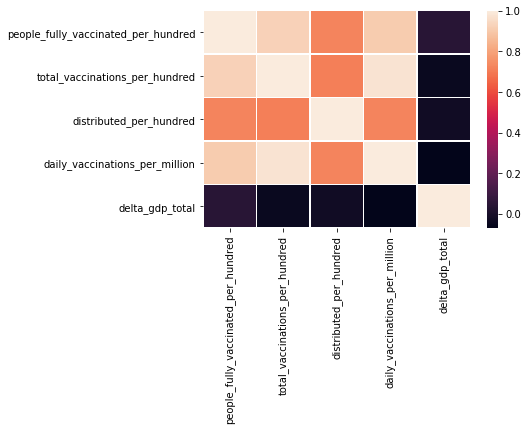

 Private industries
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.134983   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.060671   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hund

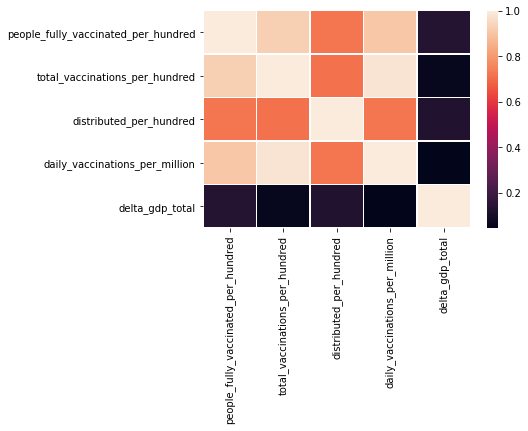

   Agriculture, forestry, fishing and hunting
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.050390   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.098075   

                                     distributed_per_hundred  \
people

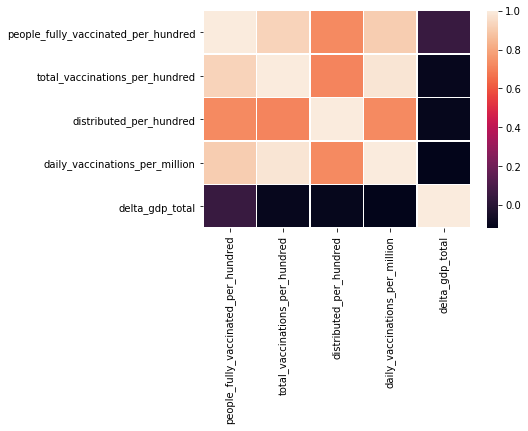

   Mining, quarrying, and oil and gas extraction
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.273113   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.185929   

                                     distributed_per_hundred  \
peo

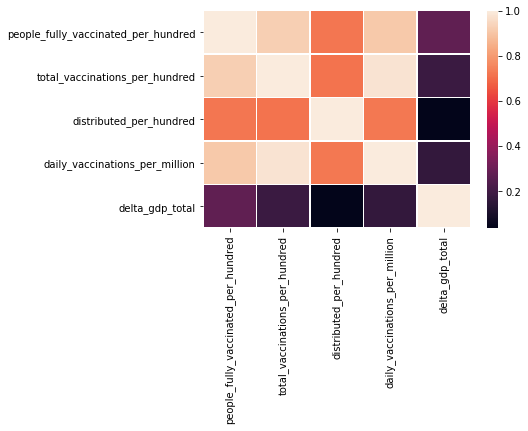

   Utilities
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.086046   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.019622   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred    

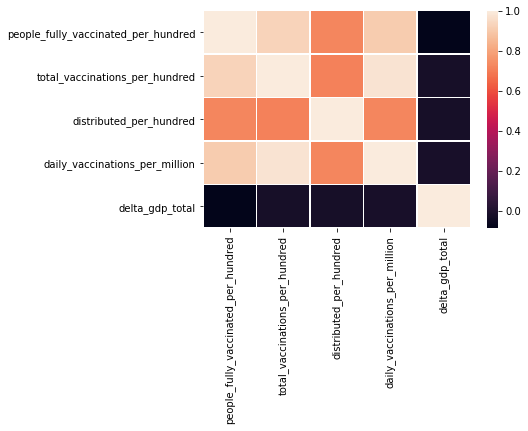

   Construction
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.054405   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.083905   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred 

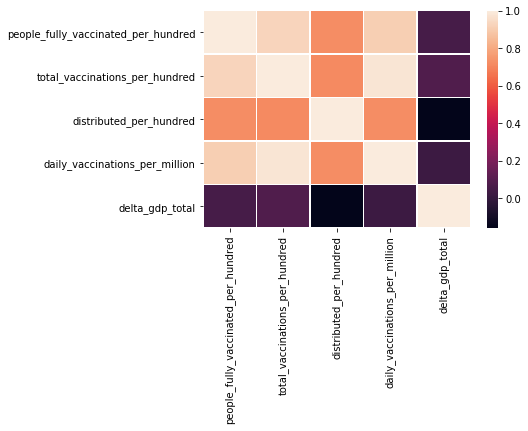

   Manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.103856   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.181064   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred

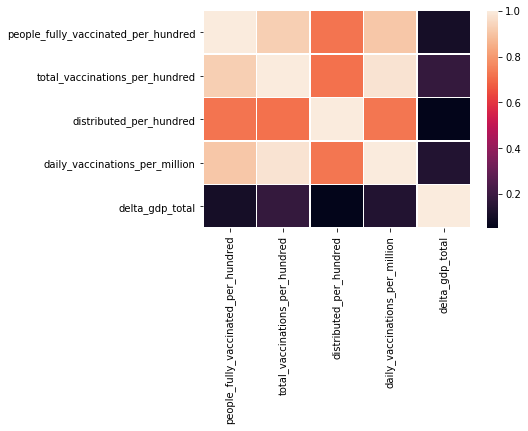

     Durable goods manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.129671   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.144757   

                                     distributed_per_hundred  \
people_fully_vaccin

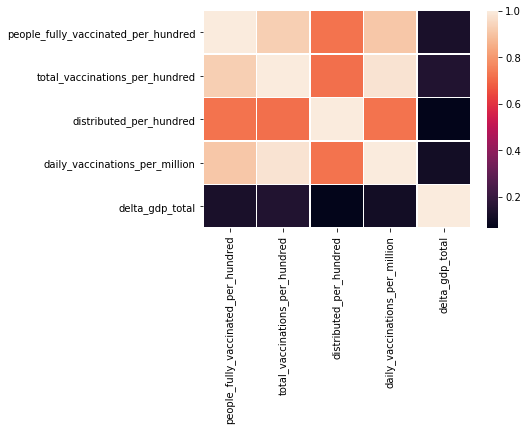

     Nondurable goods manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.023926   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.100028   

                                     distributed_per_hundred  \
people_fully_vac

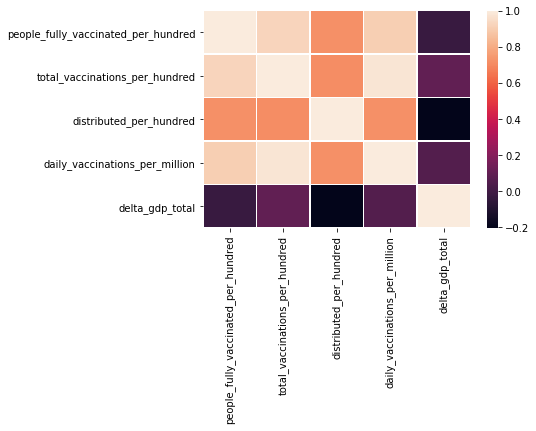

   Wholesale trade
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.112440   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.033935   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

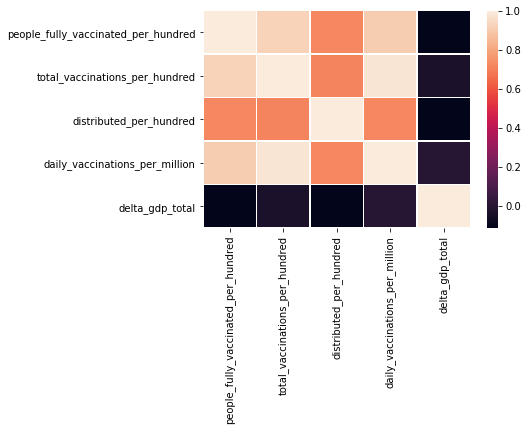

   Retail trade
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.231454   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.155283   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred 

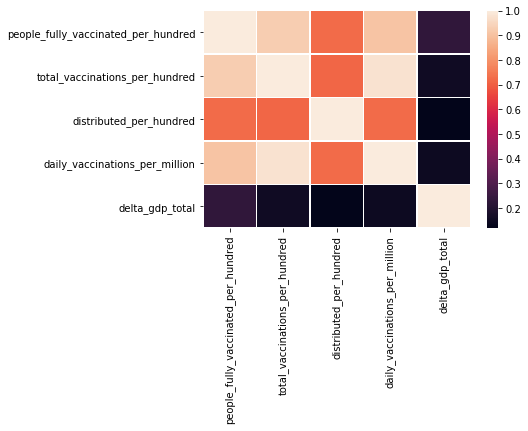

   Transportation and warehousing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.042881   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.018968   

                                     distributed_per_hundred  \
people_fully_vacci

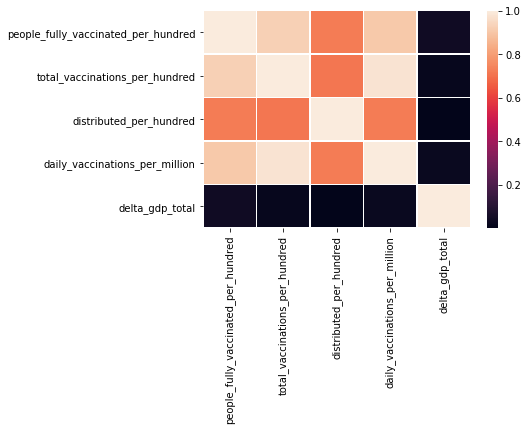

   Information
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.286933   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.213213   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred  

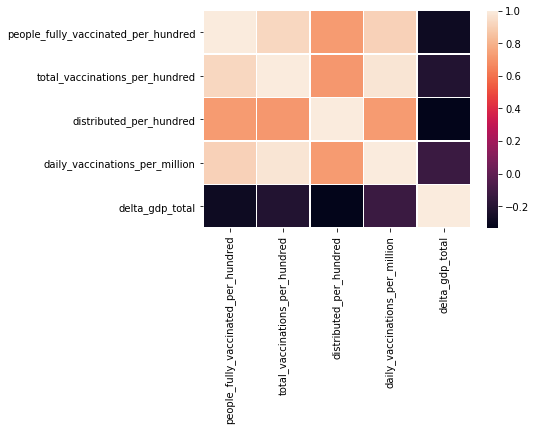

   Finance and insurance
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.081579   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.086976   

                                     distributed_per_hundred  \
people_fully_vaccinated_per

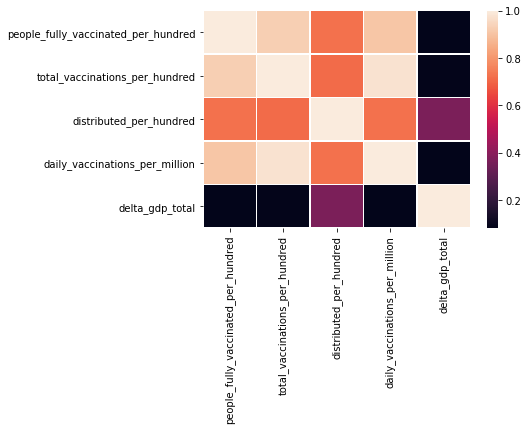

   Real estate and rental and leasing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.370728   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.336698   

                                     distributed_per_hundred  \
people_fully_v

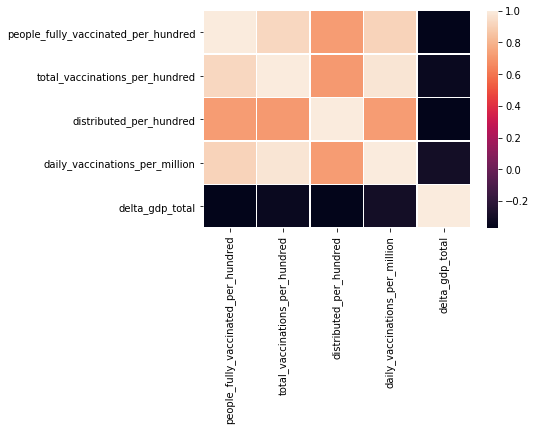

   Professional, scientific, and technical services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.236458   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.265885   

                                     distributed_per_hundred  \


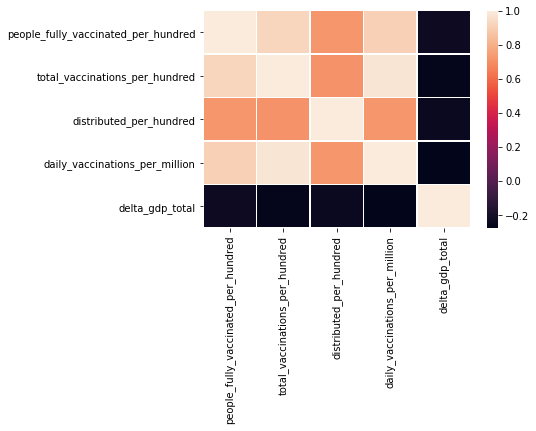

   Management of companies and enterprises
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.017137   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.020171   

                                     distributed_per_hundred  \
people_fu

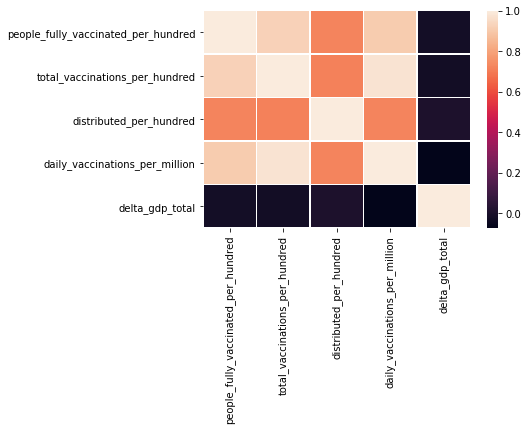

   Administrative and support and waste management and remediation services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.001121   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.038921   

                                     dis

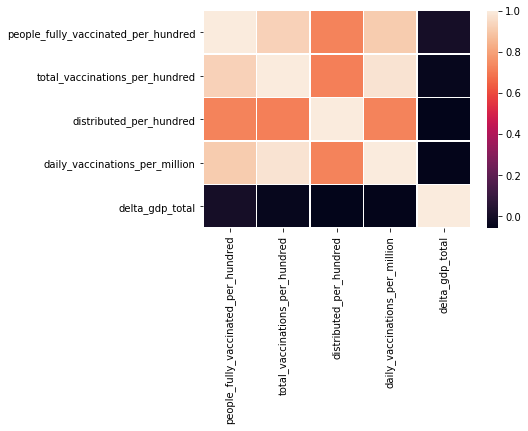

   Educational services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.058443   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.086844   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_

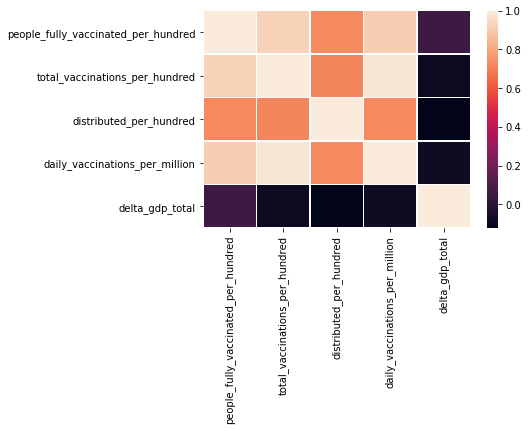

   Health care and social assistance
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.197434   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.240293   

                                     distributed_per_hundred  \
people_fully_va

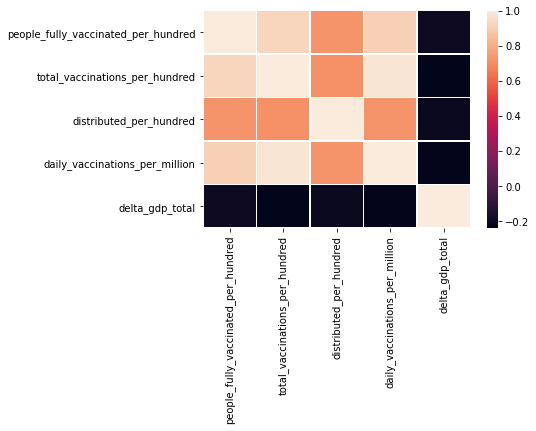

   Arts, entertainment, and recreation
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.043036   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.108498   

                                     distributed_per_hundred  \
people_fully_

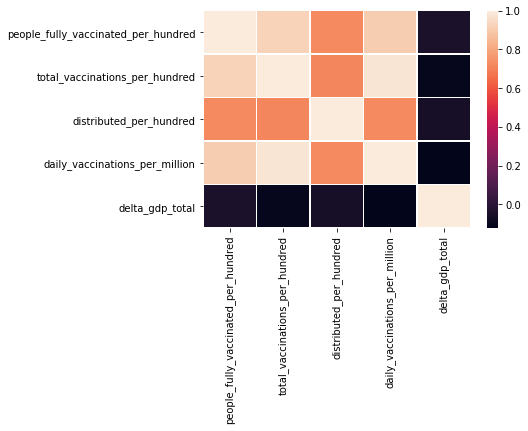

   Accommodation and food services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.073494   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.003668   

                                     distributed_per_hundred  \
people_fully_vacc

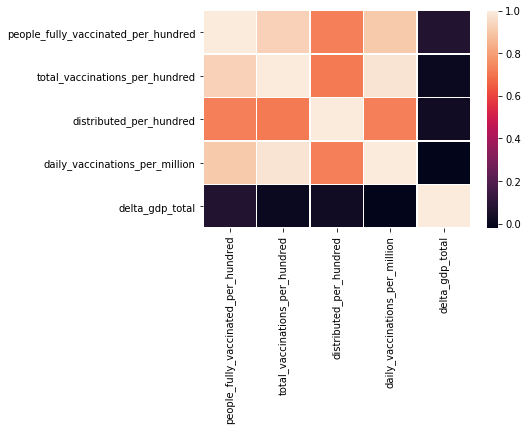

   Other services (except government and government enterprises)
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.031515   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.054048   

                                     distributed_pe

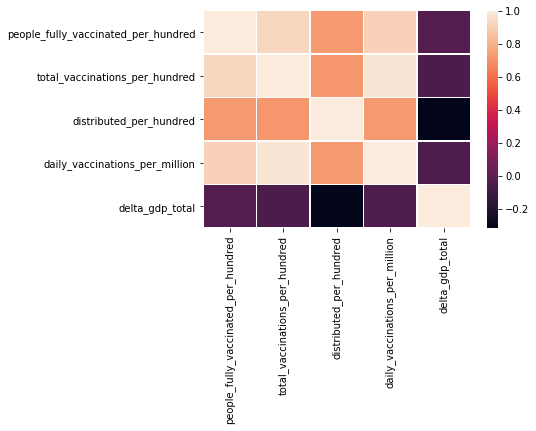

 Government and government enterprises
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.194405   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.273733   

                                     distributed_per_hundred  \
people_fully_

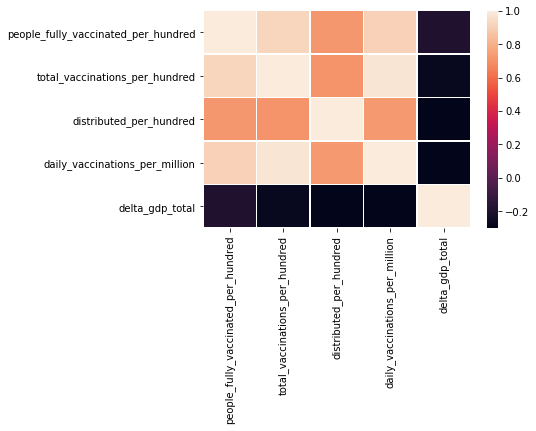

  Federal civilian
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.147482   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.154804   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

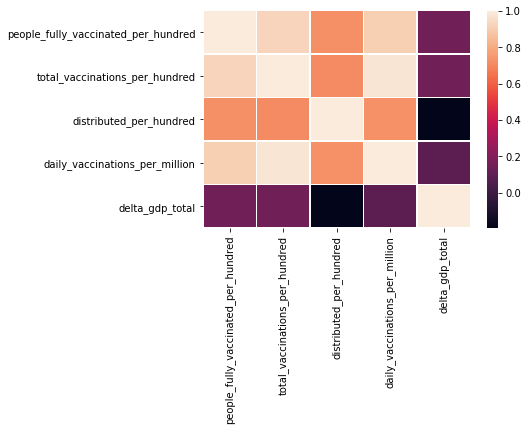

  Military
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                 0.080650   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                            0.002423   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred      

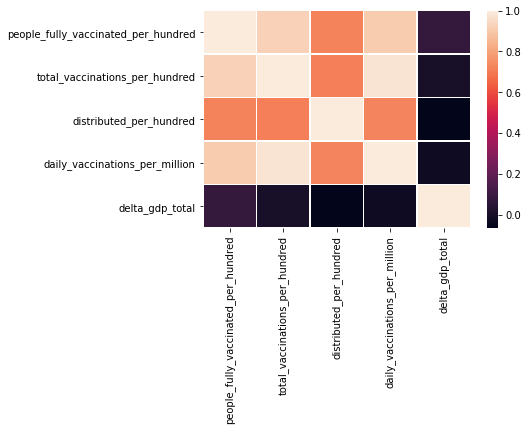

  State and local
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.928267   
distributed_per_hundred                                         0.724798   
daily_vaccinations_per_million                                  0.910067   
delta_gdp_total                                                -0.269274   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.928267   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.715073   
daily_vaccinations_per_million                             0.978356   
delta_gdp_total                                           -0.294658   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundre

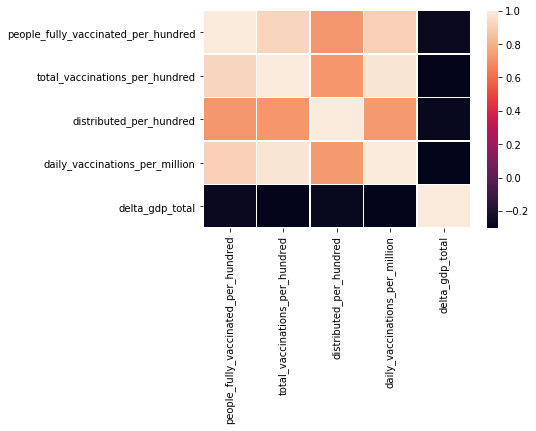

In [124]:
for description_value in gdp_df['Description'].unique():
    gdp_df_total = gdp_df[gdp_df['Description'] == description_value].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)
    gdp_df_total.replace('(D)',None,inplace=True)
    delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
    delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)
    summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
    summarized_gdp_total['delta_gdp_total'] = delta_2021_Q1
    summarized_gdp_total['location'] = gdp_df_total['location']
    summarized_gdp_total.reset_index(drop=True, inplace=True)
    summarized_gdp_total['quarter'] = ['2021:Q1']*50
    summarized_total = summarized_vax_quarterly.merge(summarized_gdp_total, on=['location','quarter'])
    
    print(description_value)
    print(summarized_total.corr())
    ax = sns.heatmap(summarized_total.corr(), linewidth=0.5)
    plt.show()

Categories with reasonable correlation. All industry total -> Private industries:
* Mining, quarrying, and oil and gas extraction
* * delta_gdp_total  
* * people_fully_vaccinated_per_hundred         -0.672071  
* * total_vaccinations_per_hundred              -0.662365 
* * distributed_per_hundred                     -0.694135  
* * daily_vaccinations_per_million              -0.044844 
* * delta_gdp_total                             1.000000  

* Utilities
* * delta_gdp_total  
* * people_fully_vaccinated_per_hundred         -0.696827  
* * total_vaccinations_per_hundred              -0.678444   
* * distributed_per_hundred                     -0.694265  
* * daily_vaccinations_per_million              -0.068749  
* * delta_gdp_total                             1.000000  

* Real estate and rental and leasing
* * delta_gdp_total  
* * people_fully_vaccinated_per_hundred         0.727329  
* * total_vaccinations_per_hundred              0.712016  
* * distributed_per_hundred                     0.731928  
* * daily_vaccinations_per_million              0.022353  
* * delta_gdp_total                             1.000000  

* Accommodation and food services
* * delta_gdp_total  
* * people_fully_vaccinated_per_hundred         0.782489  
* * total_vaccinations_per_hundred              0.764932  
* * distributed_per_hundred                     0.785389  
* * daily_vaccinations_per_million              0.207062  
* * delta_gdp_total                             1.000000  

* Other services (except government and government enterprises)
* * delta_gdp_total  
* * people_fully_vaccinated_per_hundred         0.833123 
* * total_vaccinations_per_hundred              0.819133 
* * distributed_per_hundred                     0.824039  
* * daily_vaccinations_per_million              0.156794    
* * delta_gdp_total                             1.000000 

Categories with slightly smaller correlation (around .3 - .4)
* Finance and Insurance
* Nondurable goods and manufacturing
* Wholesale trade
* Administrative and support and waste management and remediation services
* Health care and social assistance
* Government and government enterprises
* Federal Civilian
* State and local

Smaller correlation (around .2)
* All industry total
* Private industries
* Agriculture, forestry, fishing and hunting
* Construction
* Manufacturing
* Retail trade
* Transportation and warehousing
* Information
* Professional, scientific, and technical services
* Educational services


# Graphing Results

In [36]:
# Imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [31]:
gdp_lr_preprocess = pd.read_csv('../data/gdp-data/SQGDP2__ALL_AREAS_2005_2021.csv')
gdp_lr_preprocess = gdp_lr_preprocess[gdp_lr_preprocess['GeoName'].isin(state_names)]
gdp_lr_preprocess = gdp_lr_preprocess[gdp_lr_preprocess['Description'] == 'All industry total'].drop(['GeoFIPS','TableName','Region','LineCode','IndustryClassification','Description', 'Unit'], axis=1)

In [88]:
X_gdp = pd.DataFrame(columns=['location','time','GDP'])
for index,row in gdp_lr_preprocess.iterrows():
    state_X = pd.DataFrame(columns=['location','time','GDP'])
    state_X['time'] = range(0,66)
    state_X['time'] = state_X['time'].astype(float)
    state_X['GDP'] = row[1:].values.astype(float)
    state_X['location'] = row['GeoName']
    X_gdp = pd.concat([X_gdp,state_X])

In [89]:
X_gdp[X_gdp['location'] == 'California'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  66 non-null     object 
 1   time      66 non-null     float64
 2   GDP       66 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.1+ KB


### Graphing GDP w.r.t. time within California

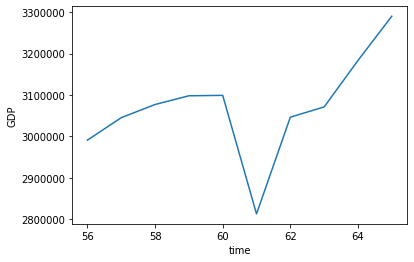

In [129]:
sns.lineplot(data = X_gdp[(X_gdp['location'] == 'California') & (X_gdp['time']>=56)], x='time', y='GDP')

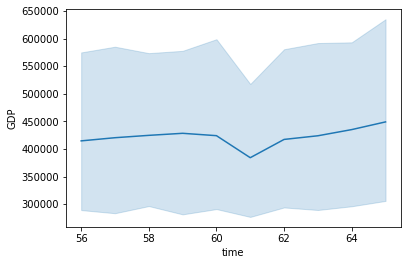

In [131]:
sns.lineplot(data = X_gdp[(X_gdp['time']>=56)], x='time', y='GDP')

The two graphs above are useful because they shows that not every state's economic recovery occured at the same speed.

### Plotting Average GDP Increase Rate w.r.t. Vaccination Rate

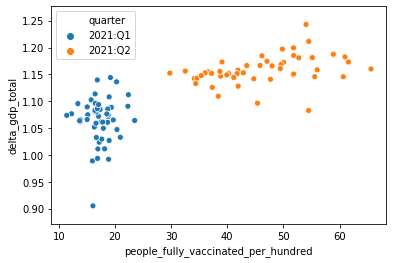

In [122]:
gdp_df_total = gdp_df[gdp_df['Description'] == '   Accommodation and food services'].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)
gdp_df_total.replace('(D)',None,inplace=True)
delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)
summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
summarized_gdp_total['delta_gdp_total'] = pd.concat([delta_2021_Q1,delta_2021_Q2])
summarized_gdp_total['location'] = pd.concat([gdp_df_total['location'],gdp_df_total['location']])
summarized_gdp_total.reset_index(drop=True, inplace=True)
summarized_gdp_total['quarter'] = pd.concat([pd.Series(['2021:Q1']*50),pd.Series(['2021:Q2']*50)]).to_list()
summarized_total = summarized_vax_quarterly.merge(summarized_gdp_total, on=['location','quarter'])

sns.scatterplot(data = summarized_total, x='people_fully_vaccinated_per_hundred', y='delta_gdp_total', hue='quarter')

In [ ]:
summarized_total['delta_gdp_total'] = summarized_total['delta_gdp_total'].astype(float)

# Difference in Differences Analysis for Causality

Looking for casuality in following categories
* Mining, quarrying, and oil and gas extraction
* Utilities
* Accommodation and food services
* Real estate and rental and leasing
* Other services (except government and government enterprises)
* Health care and social assistance
* All industry total

### Linear Regression Predictor of GDP

In order to do the analysis, we must first conduct a linear regression prediction for 2021 GDP using data from 2020. We can also use GDP predictions from other subsidiaries (TODO)

In [37]:
# Training everything w/ onehotencoding instead of training a separate model for individual states
# drop_enc = OneHotEncoder(drop='first').fit(gdp_lr_preprocess)

In [ ]:
# train a linear regression per each state
for state in state_names:
    train = gdp_lr_preprocess[gdp_lr_preprocess['GeoName'] == state].drop(['GeoName','2021:Q1', '2021:Q2'], axis=1)
    

In [ ]:
for year in range(2005,2022):
    for quarter in range(1,5):
        gdp_lr_preprocess[str(year)+':Q'+str(quarter)] = gdp_lr_preprocess[str(year)+':Q'+str(quarter)]

delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)


summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
summarized_gdp_total['delta_gdp_total'] = pd.concat([delta_2021_Q1,delta_2021_Q2])
summarized_gdp_total['location'] = pd.concat([gdp_df_total['location'],gdp_df_total['location']])
summarized_gdp_total.reset_index(drop=True, inplace=True)
summarized_gdp_total['quarter'] = pd.concat([pd.Series(['2021:Q1']*50),pd.Series(['2021:Q2']*50)]).to_list()